# Implementing the "Phoneme Level Lyrics Alignment and Text-Informed Singing Voice Separation" paper for the Vocadito Dataset


This colab contains the process to apply the algorithm presented in the paper to the tracks composing the Vocadito dataset.

Vocadito :

    Paper : https://arxiv.org/pdf/2110.05580.pdf
    Dataset : https://zenodo.org/record/5578807

Algorithm :

    Paper : https://hal.telecom-paris.fr/hal-03255334/file/2021_Phoneme_level_lyrics_alignment_and_text-informed_singing_voice_separation.pdf
    GitHub : https://github.com/schufo/lyrics-aligner


# Import, Setup & Conda environment

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

!pip install mirdata
import mirdata

import librosa

from google.colab import output
output.clear()

In [2]:
# Downloading the dataset and validating the installation with a CRC check.
vocadito = mirdata.initialize("vocadito")
vocadito.download()
vocadito.validate()

INFO: Downloading ['zenodo'] to /root/mir_datasets/vocadito
INFO: [zenodo] downloading Vocadito.zip
INFO: /root/mir_datasets/vocadito/Vocadito.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
100%|██████████| 40/40 [00:00<00:00, 222.97it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

In [3]:
# Condacolab used in order to use the SoTA algorithm by K. Schulze-Forster
!pip install -q condacolab

In [4]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


# Setting up the algorithm

Following the `Installation` part from https://github.com/schufo/lyrics-aligner#readme 

In [5]:
!git clone https://github.com/schufo/lyrics-aligner.git

fatal: destination path 'lyrics-aligner' already exists and is not an empty directory.


In [6]:
%cd /content/lyrics-aligner

/content/lyrics-aligner


In [7]:
%%time
# Setting up the conda environment
# /!\ This takes a long time ... 25mn in average

# Here, we run the model on a CPU, but GPU might work ?
!conda env create -f environment_cpu.yml
output.clear()

CPU times: user 13.2 s, sys: 1.3 s, total: 14.5 s
Wall time: 19min 21s


## Preparing the data

Based on the `Data preparation` part in https://github.com/schufo/lyrics-aligner#readme

Automated in Python. Working as of 20/04/2023

In [8]:
# Used to automatize the access to the CMU dictionary : http://www.speech.cs.cmu.edu/tools/lextool.html

import os
import requests
import ssl
from urllib.request import urlretrieve
from urllib.request import urlopen
import urllib.parse

In [9]:
!NAME=VOCADITO
NAME='VOCADITO'

In [10]:
# For the Vocadito dataset, we need to fix 5 files containing problematic characters:

# 23 : changing 'à' in 'a' and 'trempez-la' in 'trempez la'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_23_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')
    text = text.replace('trempez-la', 'trempez la')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_23_lyrics.txt', 'w') as f:
    f.write(text)

# 30 : changing 'à' in 'a'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_30_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_30_lyrics.txt', 'w') as f:
    f.write(text)

# 31 : changing 'à' in 'a'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_31_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_31_lyrics.txt', 'w') as f:
    f.write(text)

# 35 : Removing the chinese characters that are at the end of the lyrics
import re
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_35_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub('[\u4e00-\u9fff]+', '', text)
text = text.replace('-','')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_35_lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(text)

# 36 : Removing the chinese characters that are at the end of the lyrics
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_36_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub('[\u4e00-\u9fff]+', '', text)
text = text.replace('-','')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_36_lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(text)

In [11]:
# 1 - Generate a .txt-file with a list of unique words - VOCADITO_word_list.txt here
!python make_word_list.py /root/mir_datasets/vocadito/Annotations/Lyrics --dataset-name $NAME

with open(f'/content/lyrics-aligner/files/{NAME}_word_list.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    words = data.split()

print(words[:30])

["'cause", "'oe", 'a', "a'e", 'about', 'acuerdo', 'again', 'ah', 'ainsi', 'ako', 'al', 'alarm', 'alimango', 'all', 'allant', 'allez', 'aloha', 'alone', 'and', 'ang', 'anirem', 'any', 'arar', 'are', 'arrabales', 'arreando', 'as', 'at', 'au', 'aussi']


In [12]:
# 2 - Go to http://www.speech.cs.cmu.edu/tools/lextool.html, upload NAME_word_list.txt as word file, and click COMPILE.
# We automatize this step in Python using the BeautifulSoup library

# Submit the file NAME_word_list.txt generated in step #1
form_data = {
    'wordfile': ('filename.txt', open(f"/content/lyrics-aligner/files/{NAME}_word_list.txt", 'rb'), 'text/plain')
}
response = requests.post('http://www.speech.cs.cmu.edu/cgi-bin/tools/logios/lextool2.pl', files=form_data)

# Verification that the form submission was successful
if response.status_code == 200:
    print("Form submitted successfully!")
    resp = response.content
else:
    print("Form submission failed : " + str(response))
    print(response)

Form submitted successfully!


In [13]:
# From the response, we recover the URL of the *.dict file generated
import re 

match = re.search(r'DICT\s*(http\S*\.dict)', resp.decode())
if match:
    url = match.group(1)
    print(url)

# Send a GET request to the URL and get the response content
response = requests.get(url)

# Verification that the form submission was successful
if response.status_code == 200:
    print("Received the .dict successfully!")
else:
    print("Issue receiving the .dict : " + str(response))
    print(response)

http://www.speech.cs.cmu.edu//tools/product/1682081993_1614896//3215.dict
Received the .dict successfully!


In [14]:
# Step #4 : Copy the whole list and paste it into NAME_word2phoneme.txt in the files directory

with open(f'/content/lyrics-aligner/files/{NAME}_word2phonemes.txt', 'wb') as f:
    f.write(response.content)

In [15]:
# Step #5 : Running this command will generate a Python dictionary to translate each word into phonemes and save it as NAME_word2phonemes.pickle in files.

!python make_word2phoneme_dict.py --dataset-name $NAME

## Using the model

Part based on the `Usage` part of https://github.com/schufo/lyrics-aligner#readme
Cf this for flags description.

In [16]:
!pip install librosa
import librosa
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

output.clear()

In [17]:
# Adapting Vocadito's structure to the algorithm's need.

%cd /root/mir_datasets/vocadito/Annotations
!mkdir Lyrics_process && cp ./Lyrics/vocadito_*_lyrics.txt Lyrics_process && cd Lyrics_process && rename 's/_lyrics//' *
%cd -

/root/mir_datasets/vocadito/Annotations
/content/lyrics-aligner


In [18]:
# Running the model for every file in our folder
# It can takes a few minutes

%%time

!python align.py /root/mir_datasets/vocadito/Audio  /root/mir_datasets/vocadito/Annotations/Lyrics_process \
--lyrics-format w --onsets pw --dataset-name $NAME --vad-threshold 0

Running model on CPU.
Processing vocadito_1.wav ...
Done.
Processing vocadito_10.wav ...
Done.
Processing vocadito_11.wav ...
Done.
Processing vocadito_12.wav ...
Done.
Processing vocadito_13.wav ...
Done.
Processing vocadito_14.wav ...
Done.
Processing vocadito_15.wav ...
Done.
Processing vocadito_16.wav ...
Done.
Processing vocadito_17.wav ...
Done.
Processing vocadito_18.wav ...
Done.
Processing vocadito_19.wav ...
Done.
Processing vocadito_2.wav ...
Done.
Processing vocadito_20.wav ...
Done.
Processing vocadito_21.wav ...
Done.
Processing vocadito_22.wav ...
Done.
Processing vocadito_23.wav ...
Done.
Processing vocadito_24.wav ...
Done.
Processing vocadito_25.wav ...
Done.
Processing vocadito_26.wav ...
Done.
Processing vocadito_27.wav ...
Done.
Processing vocadito_28.wav ...
Done.
Processing vocadito_29.wav ...
Done.
Processing vocadito_3.wav ...
Done.
Processing vocadito_30.wav ...
Done.
Processing vocadito_31.wav ...
Done.
Processing vocadito_32.wav ...
Done.
Processing vocadito

# Plotting the results

We propose here a way to plot the model's resulting alignment prediction.

In [19]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [20]:
def plotting_pred(number, starting_time, finish_time):
  wav_path = f'/root/mir_datasets/vocadito/Audio/vocadito_{number}.wav'
  F0_path = f'/root/mir_datasets/vocadito/Annotations/F0/vocadito_{number}_f0.csv'
  lyrics_path = f'/root/mir_datasets/vocadito/Annotations/Lyrics_process/vocadito_{number}.txt'
  notes_a1_path = f'/root/mir_datasets/vocadito/Annotations/Notes/vocadito_{number}_notesA1.csv'
  notes_a2_path = f'/root/mir_datasets/vocadito/Annotations/Notes/vocadito_{number}_notesA2.csv'
  words_onsets_path = f'/content/lyrics-aligner/outputs/VOCADITO/word_onsets/vocadito_{number}.txt'
  phoneme_onsets_path = f'/content/lyrics-aligner/outputs/VOCADITO/phoneme_onsets/vocadito_{number}.txt'

  time_ind = []
  f0_ind = []

  time_a1_ind = []
  dur_a1_ind = []
  pitch_a1 = []

  time_a2_ind = []
  dur_a2_ind = []
  pitch_a2 = []  

  word = []
  timing = []
  dico_word = {}

  phonemes = []
  timing_pho = []
  dico_pho = {}

  with open(F0_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_ind.append(float(line[0]))
          f0_ind.append(float(line[1]))

  with open(notes_a1_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_a1_ind.append(float(line[0]))
          pitch_a1.append(float(line[1]))
          dur_a1_ind.append(float(line[2]))  

  with open(notes_a2_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_a2_ind.append(float(line[0]))
          pitch_a2.append(float(line[1]))
          dur_a2_ind.append(float(line[2]))  

  with open(words_onsets_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
        a,b = line[0].split('\t')
        word.append(a)
        timing.append(float(b))
        
  # Iterate through the lists and add key-value pairs to the dictionary
  for i in range(len(word)):
      dico_word[timing[i]] = word[i]

  with open(phoneme_onsets_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
        a,b = line[0].split('\t')
        phonemes.append(a)
        timing_pho.append(float(b))

  # Iterate through the lists and add key-value pairs to the dictionary
  for i in range(len(phonemes)):
      dico_pho[timing_pho[i]] = phonemes[i]

  plt.rcParams['figure.figsize'] = (20,8)

  fig, ax = plt.subplots()

  for i in range(len(time_a1_ind)):
    if time_a1_ind[i] > starting_time and time_a1_ind[i] < finish_time:
      ax.add_patch(Rectangle((time_a1_ind[i],pitch_a1[i]-5), dur_a1_ind[i], 10, alpha=0.2, facecolor='b'))

  for i in range(len(time_a2_ind)):
    if time_a2_ind[i] > starting_time and time_a2_ind[i] < finish_time:
      ax.add_patch(Rectangle((time_a2_ind[i],pitch_a2[i]-5), dur_a2_ind[i], 10, alpha=0.2, facecolor='r'))

  tmp = min(x for x in f0_ind if x != 0) - 40
  for i in dico_word.keys():
    if(i > starting_time and i < finish_time):
      ax.text(i, tmp, f'{dico_word[i]}', size=30)
      plt.axvline(x=i, alpha = 0.5, c ='maroon', ls='-')

  tmp = min(x for x in f0_ind if x != 0) - 70
  for i in dico_pho.keys():
    if(i > starting_time and i < finish_time):
      ax.text(i, tmp, f'{dico_pho[i]}',size=15)
      plt.axvline(x=i, alpha = 0.2, c='purple', ls='dotted')

  for i in range(len(f0_ind)):
    if(time_ind[i] < finish_time and time_ind[i] > starting_time):
      if f0_ind[i] > 10:
        ax.plot(time_ind[i], f0_ind[i],'ok',alpha = 0.4)
      else:
        ax.plot(time_ind[i], 100)

  plt.xlim(xmin=starting_time, xmax=finish_time)
  plt.ylim(ymin=tmp - 70, ymax = max(f0_ind)+20)

  # Legend 
  plt.axvline(x=-1, alpha = 0.2, c='purple', ls='dotted', label = 'Onset of a phoneme')
  plt.axvline(x=-1, alpha = 0.5, c ='maroon', ls='-', label = 'Onset of a word')
  ax.plot(-1, 0,'ok',alpha = 0.4, label='A pitch value')
  ax.add_patch(Rectangle((-1,0), 0, 0, alpha=0.2, facecolor='b', label = 'Annotations from A1'))
  ax.add_patch(Rectangle((-1,0), 0, 0, alpha=0.2, facecolor='r', label = 'Annotations from A2'))
  plt.legend()
  plt.xlabel('Time (sec)')
  plt.ylabel('Pitch (frequency)')

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


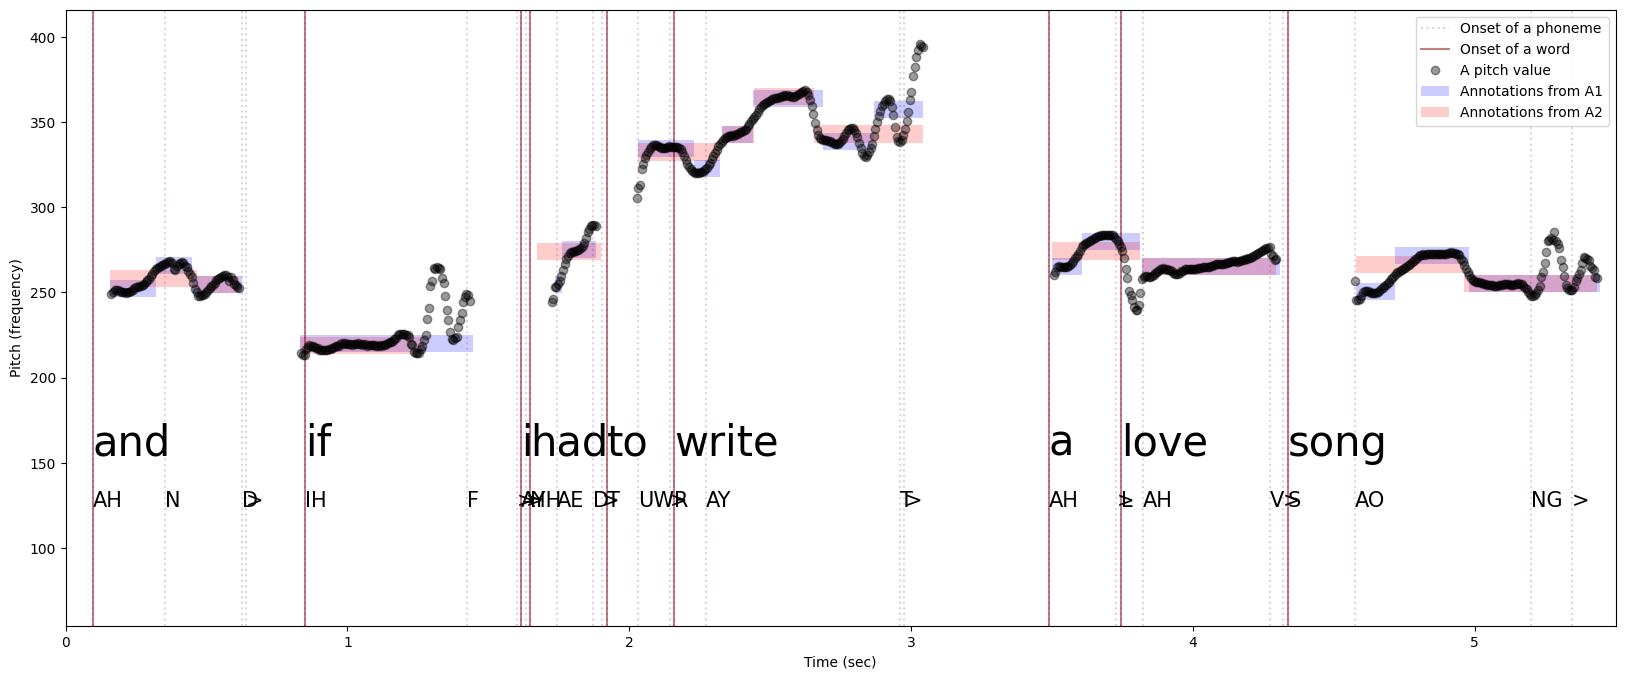

In [21]:
plotting_pred(number = 6,starting_time = 0, finish_time = 5.5)